## Find indent

To simplify the work for video interpolation network, it is desirable to find an indent from the first frame, such that the last frame of the first video part is similar to the first frame of the second video part

In [13]:
import cv2
import numpy as np

FPS = 25

# load mp4 file to numpy array
def load_video(file_path):
    cap = cv2.VideoCapture(file_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

video_array = load_video("original.mp4")

In [14]:
# compute the LPIPS distance between frames (last frame of the first part and first frame of the second part)
# to find a good interpolation point

import lpips
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loss_fn = lpips.LPIPS().to(device)

frame_1 = FPS * 16
frame_2 = FPS * 30
inbetween_duration = FPS * 5
num_frames_to_interpolate = 3


distances_lpips = []
for indent in range(inbetween_duration):
    frame_left = frame_1 + indent
    frame_right = frame_2 - inbetween_duration + indent + num_frames_to_interpolate
    frame_left = video_array[frame_left]
    frame_right = video_array[frame_right]
    frame_left = torch.tensor(frame_left).permute(2, 0, 1).unsqueeze(0).float() / 255
    frame_right = torch.tensor(frame_right).permute(2, 0, 1).unsqueeze(0).float() / 255
    distance = loss_fn(frame_left.to(device), frame_right.to(device)).cpu().item()
    distances_lpips.append(distance)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/opt/conda/envs/vfimamba/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/vfimamba/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /opt/conda/envs/vfimamba/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/opt/conda/envs/vfimamba/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_locat

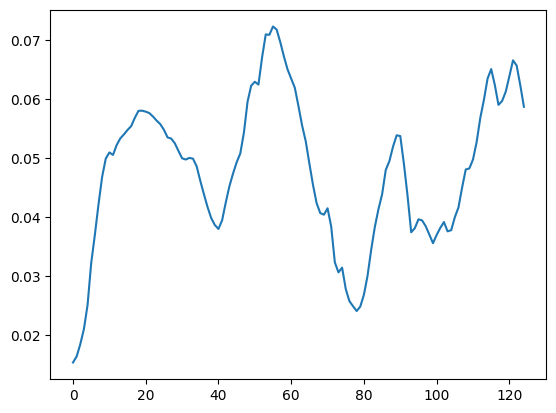

In [15]:
plt.plot(distances_lpips)
plt.show()

In [16]:
import matplotlib.pyplot as plt

distances_lpips = np.array(distances_lpips)
smallest_indices = distances_lpips.argsort()[:100]
print(smallest_indices)

[  0   1   2   3  78  79  77   4  76  80  75  81  73  74   5  72  82  99
   6 100  98  93 103 104  40  94 101  83  71  97  39 102  96  41  95  38
 105  69  68  84  70 106  37   7  67  42  92  85  36 107  43  66  35   8
  44  86 108 109  34  91  65  45  87  31 110  33   9  30  32  11  46  10
  29  88  12  28 111  64  27  13  26  90  89  14  47  15  25  16  63  24
  23 112  17  22  21  20  18  19 124  62]


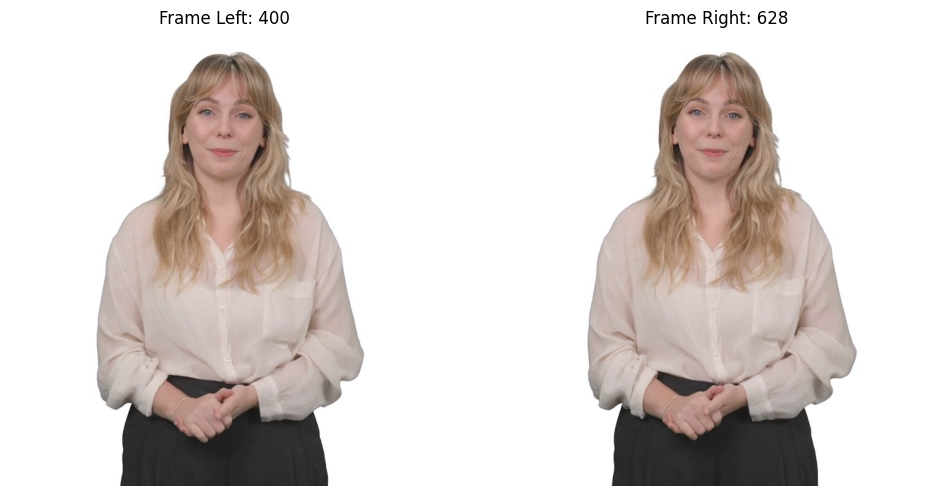

In [17]:
# it seems that the best indent according to lpips is 0, let's visualize the frames

import matplotlib.pyplot as plt
import cv2
import numpy as np

distances_lpips = np.array(distances_lpips)
smallest_indices = distances_lpips.argsort()[:1]

for indent in smallest_indices:
    frame_left = frame_1 + indent
    frame_right = frame_2 - inbetween_duration + indent + 3

    # Extract the frames and crop them
    frame_left_image = video_array[frame_left][:, 300:-300]
    frame_right_image = video_array[frame_right][:, 300:-300]

    # Convert frames from BGR to RGB for display
    frame_left_image = cv2.cvtColor(frame_left_image, cv2.COLOR_BGR2RGB)
    frame_right_image = cv2.cvtColor(frame_right_image, cv2.COLOR_BGR2RGB)

    # Plot the frames side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(frame_left_image)
    axes[0].set_title(f"Frame Left: {frame_left}")
    axes[0].axis("off")

    axes[1].imshow(frame_right_image)
    axes[1].set_title(f"Frame Right: {frame_right}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

Indeed, the frames are very similar visually, so we will simply use no indent (probably the task was artificially designed that way for simplicity)